In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import wandb
import torch
 
from torchvision import models
from gpu_mem_track import MemTracker
torch.autograd.set_detect_anomaly = True

In [2]:
# Constants
H_tower = 80
H_HR = 8
W_HR = 7

import pandas as pd
data = pd.read_excel('../data/附件.xlsx', sheet_name='Sheet1')
initial_position = data.values


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
# 常数计算
## DNI
def cal_DNI(H,sin_alpha):
    """
    H: 海拔高度, km
    """
    a = 0.4237 - 0.00821 * (6 - H ) ** 2
    b = 0.5055 + 0.00595 * (6.5 - H ) ** 2
    c = 0.2711 + 0.01858 * (2.5 - H ) ** 2
    G0 = 1.366 # kW/m^2
    DNI = G0 * (a+b*np.exp(-c/sin_alpha))
    return DNI

def cal_sunlight_angle(phi,H):
    """
    计算太阳高度角
    phi: 纬度
    """
    phi = phi * np.pi / 180
    omega_list = [-torch.pi/4,
                  -torch.pi/8,
                  0,
                  torch.pi/8,
                  torch.pi/4]
    omega_list = torch.tensor(omega_list).unsqueeze(0)
    month_list = range(3,15)
    month_list = torch.tensor(month_list).unsqueeze(1)
    input = torch.zeros((12*5,3))
    sin_delta = torch.sin(2*np.pi*(30*(month_list-3))/365)*np.sin(2*np.pi/365*23.45)
    cos_delta = torch.sqrt(1-sin_delta**2)
    # sin_alpha is a tensor of size (len(month_list),len(omega_list))
    sin_alpha = np.sin(phi) * sin_delta + np.cos(phi) * cos_delta * torch.cos(omega_list)
    cos_alpha = torch.sqrt(1 - sin_alpha ** 2)
    # cos_gamma is a tensor of size (len(month_list),len(omega_list))
    cos_gamma = (sin_delta - sin_alpha * np.sin(phi)) / (np.cos(phi) * cos_alpha)
    cos_gamma = torch.clamp(cos_gamma,min=-1,max=1)
    # print('cos_gamma',cos_gamma)
    alpha = torch.atan(sin_alpha / cos_alpha) # is a tensor of size (12,5)
    gamma = torch.acos(cos_gamma) # is a tensor of size (12,5)

    DNI = cal_DNI(H,sin_alpha) # is a tensor of size (12,5)
    # to (len(month_list)*len(omega_list),3)
    input[:,2] = DNI.view(-1)
    input[:,0] = alpha.view(-1)
    input[:,1] = gamma.view(-1)

    # print('alpha',alpha*180/np.pi)
    # print('sin_delta',sin_delta)
    # print('sin_alpha',sin_alpha)
    # to numpy
    input = input.numpy()
    return input
    

In [4]:
class reflect_matrix(torch.nn.Module):
    def __init__(self, num_panel, trainning_dict, initial_posit, initial_areas, initial_heights):
        """
        num_panel: number of panels
        parameters: the coordinates of the reflect matrix, (x, y)
        areas: the areas of each panel, can be different, paremeters: height, width - (num_panel, 2)
        heights: the heights of each panel, can be different
        """
        super(reflect_matrix, self).__init__()
        self.num_panel = num_panel
        self.x = torch.nn.Parameter(torch.tensor(initial_posit[:, 0]).unsqueeze(0))
        self.y = torch.nn.Parameter(torch.tensor(initial_posit[:, 1]).unsqueeze(0))

        self.H = torch.nn.Parameter(torch.tensor(initial_areas[:, 0]).unsqueeze(0))
        self.W = torch.nn.Parameter(torch.tensor(initial_areas[:, 1]).unsqueeze(0))

        self.heights = torch.nn.Parameter(torch.tensor((initial_heights)).unsqueeze(0))

        for name, value in trainning_dict.items():
            if name == 'x':
                self.x.requires_grad = value
            elif name == 'y':
                self.y.requires_grad = value
            elif name == 'H':
                self.H.requires_grad = value
            elif name == 'W':
                self.W.requires_grad = value
            elif name == 'heights':
                self.heights.requires_grad = value
            else:
                print('Wrong name!'+name)
            
        self.d_HR = torch.sqrt((self.x) ** 2 + (self.y) ** 2 + (H_tower - self.heights) ** 2).to(device)
        # create a list of neighbour for each panel
        
        # print('------------------')
        #print('Shapes of parameters:')
        #print('x:', self.x.shape, 'y:', self.y.shape)
        #print('H:', self.H.shape, 'W:', self.W.shape)
        #print('heights:', self.heights.shape)
        #print('d_HR:', self.d_HR.shape)
        #print('neighbour_mask:', self.neighbour_mask.shape)
        #print('------------------')


    def cal_efficency(self, input, lower_limit = 6*1e5):
        """
        input: the input contains the information of sun light, specifically
        - data_γ: 太阳光方位角 gamma_s second column
        - data_α: 太阳光高度角 alpha_s first column
        - data_dni: DNI third column
        """
        data_γ = input[:,1].unsqueeze(1)
        data_α = input[:,0].unsqueeze(1)
        data_dni = input[:,2].unsqueeze(1)

        #print('data_γ:', data_γ)
        #print('data_α:', data_α)
        

        def cal_eta_sb(eta_cos):
            # TODO: calculate the eta_sb
            ## only calculate neighbour
            neighbour_mask = self.find_neighbour()
            ### calculate the vector from panel a to panel b, `vector_ab = posit_b - posit_a`, is a tensor of size (num_panel, num_panel, 3)
            vector_ab = torch.cat((self.x.unsqueeze(2) - self.x.T.unsqueeze(2), \
                                      self.y.unsqueeze(2) - self.y.T.unsqueeze(2), \
                                      self.heights.unsqueeze(2) - self.heights.T.unsqueeze(2)), dim = 2) # is a tensor of size (num_panel, num_panel, 3)
            #### mask
            vector_ab = vector_ab * (neighbour_mask.unsqueeze(2))
            #### calculate the distance between two panels
            distance = torch.sqrt(torch.sum(vector_ab ** 2, dim = 2)) # is a tensor of size (num_panel, num_panel)
            
            

            # a2b_gamma = torch.atan2(vector_ab[:,:,0], vector_ab[:,:,1]) # is a tensor of size (num_panel, num_panel)
            # del vector_ab
            # sun_gamma = data_γ # is a tensor of size (num_case, 1)
            # tower_gamma = torch.atan2(self.x, self.y)* torch.ones_like(distance) # is a tensor of size (num_panel, num_panel)

            # delta_sun = sun_gamma.unsqueeze(1) - a2b_gamma.unsqueeze(0) # is a tensor of size (num_case, num_panel, num_panel)
            # delta_tower = tower_gamma.unsqueeze(1) - a2b_gamma.unsqueeze(0) # is a tensor of size (num_case, num_panel, num_panel)
            # del a2b_gamma, sun_gamma, tower_gamma

            # dH_sun = torch.abs(torch.sin(delta_sun) * distance.unsqueeze(0)) # is a tensor of size (num_case, num_panel, num_panel)
            # shade_H_sun = torch.max(0.5*(self.H.unsqueeze(1) + self.H.unsqueeze(2))/torch.sin(data_α.unsqueeze(1)) - dH_sun, torch.tensor(0)) # is a tensor of size (num_case, num_panel, num_panel)
            # del dH_sun
            # dL_sun = torch.max(torch.cos(delta_sun) * distance.unsqueeze(0), torch.tensor(0))
            # shade_L_sun = torch.max(0.5*(self.W.unsqueeze(1) + self.W.unsqueeze(2)) - dL_sun, torch.tensor(0))
            # del dL_sun
            # shade_area_sun = torch.sum(shade_H_sun * shade_L_sun, dim = 2)
            # del shade_H_sun, shade_L_sun


            # dH_tower = torch.abs(torch.sin(delta_tower) * distance.unsqueeze(0)) # is a tensor of size (num_case, num_panel, num_panel)
            # shade_H_tower = torch.max(0.5*(self.H.unsqueeze(1) + self.H.unsqueeze(2))/torch.sin(data_α) - dH_tower, torch.tensor(0)) # is a tensor of size (num_case, num_panel, num_panel)
            # del dH_tower
            # dL_tower = torch.max(torch.cos(delta_tower) * distance.unsqueeze(0), torch.tensor(0))
            # shade_L_tower = torch.max(0.5*(self.W.unsqueeze(1) + self.W.unsqueeze(2)) - dL_tower, torch.tensor(0))
            # del dL_tower
            # shade_area_tower = torch.sum(shade_H_tower * shade_L_tower, dim = 2)
            # del shade_H_tower, shade_L_tower

            # eta_sb = 1 - torch.sum(shade_area_sun, dim = (1,2)) / torch.sum(self.H * self.W) - \
            #     torch.sum(shade_area_tower, dim = (1,2)) / torch.sum(self.H * self.W) # is a tensor of size (num_case,)

            print('eta_sb:', eta_sb)

            # print('shade_area_in:', shade_area_in)
            # print('shade_area_out:', shade_area_out)
            # print('eta_cos:', eta_cos)
            # print('Area_approx:', Area_approx)
            # print('diagonal_approx:', diagonal_approx)
            # print('vector_ab_projection:', vector_ab_projection)
            # print('D_PQ:', D_PQ)
            # print('distance_sq:', distance_sq)
            
            #### calculate the eta_sb
            if torch.any(eta_sb < 0):
                print('eta_sb:', eta_sb)
            return eta_sb # is a tensor of size (num_case, num_panel)

        def cal_eta_cos():
            # $$cos\theta = \sqrt{\frac{1}{2}[1+\frac{1}{d_{HR}}(-xcos\alpha_ssin\gamma_s-ycos\alpha_s\cos\gamma_s+sin\alpha_s(h_1-h_2))]}$$
            A = self.x * torch.cos(data_α) * torch.sin(data_γ)
            B = self.y * torch.cos(data_α) * torch.cos(data_γ)
            C = torch.sin(data_α) * (H_tower-self.heights)
            eta_cos = torch.sqrt((1 + (1 / self.d_HR) * (- A - B + C)) / 2)
            # return size is (num_case, num_panel)
            if torch.any(eta_cos < 0):
                print('eta_cos:', eta_cos)
            return eta_cos # is a tensor of size (num_case, num_panel)
        
        def cal_eta_at():
            #calculate the eta_at
            eta_at = 0.99321 - 1.117e-4 * self.d_HR + 1.97e-8 * self.d_HR ** 2
            if torch.any(eta_at < 0):
                print('eta_at:', eta_at)
            return eta_at
        
        def cal_eta_trunc():
            #calculate the eta_trunc
            ## beta = arctan((H_tower - H_HR) / d_HR)
            beta = torch.asin((H_tower - self.heights) / self.d_HR) # is a tensor of size (1, num_panel)
            ## cos_theta_v = \sqrt{\frac{1+cos2\theta_v}{2}}=\sqrt{\frac{1+cos(\alpha_s-\beta)}{2}}
            cos_theta_v = torch.sqrt((1 + torch.cos(2 * (data_α - beta))) / 2) # is a tensor of size (num_case, num_panel)
            ## cos_theta_h = =\sqrt{\frac{1+cos2\theta_h}{2}}=-\frac{1}{\sqrt{x^2+y^2}}(xsin\gamma_s+ycos\gamma_s)
            cos_theta_h = torch.sqrt((1+(self.x * torch.sin(data_γ) + self.y * \
                             torch.cos(data_γ))/self.d_HR)/2) # is a tensor of size (num_case, num_panel)
            #print('cos_theta_v:', cos_theta_v)
            #print('cos_theta_h:', cos_theta_h)
            ## H_ratio = min(1, \frac{H_HR}{H_ref}*cos\theta_v/cos\beta)
            H_ratio = torch.min(torch.tensor(1), H_HR / (self.H * cos_theta_v / torch.cos(beta)))
            ## W_ratio = min(1, \frac{W_HR}{W_ref}*cos\theta_h)
            W_ratio = torch.min(torch.tensor(1), W_HR / (self.W * cos_theta_h))
            ## A_ratio = H_ratio * W_ratio
            A_ratio = H_ratio * W_ratio
            if torch.any(A_ratio < 0):
                print('A_ratio:', A_ratio)
            return A_ratio # is a tensor of size (num_case, num_panel)
        
        def cal_eta_ref():
            #calculate the eta_ref
            return 0.92
        
        
        
        # calculate eta
        eta_cos = cal_eta_cos()
        eta_at = cal_eta_at()
        eta_trunc = cal_eta_trunc()
        eta_ref = cal_eta_ref()
        eta_sb = cal_eta_sb(eta_cos).detach()                                

        eta = eta_sb * eta_cos * eta_at * eta_trunc * eta_ref # each is a tensor of size (num_case, num_panel)
        # eta = eta_at

        def cal_monthly_eta(eta_in):
            # calculate the monthly efficiency
            eta_in = eta_in.view(12,5,-1)
            # mean over time and panel(2&3 dimension)
            eta_in = torch.mean(eta_in, dim = (1,2))
            return eta_in

        # print('eta_daily:', cal_monthly_eta(eta))
        # print('eta_cos:', cal_monthly_eta(eta_cos))
        # # print('eta_at:', cal_monthly_eta(eta_at))
        # print('eta_trunc:', cal_monthly_eta(eta_trunc))
        # # print('eta_ref:', cal_monthly_eta(eta_ref))
        # print('eta_sb:', cal_monthly_eta(eta_sb))

        # print('data_dni:', data_dni.shape)


        # calculate the efficiency per unit area
        
        E_field = torch.sum(data_dni * eta * self.H * self.W) / 60
        Avg_E_field = torch.sum(data_dni * eta * self.H * self.W) / torch.sum(self.H * self.W)

        # penalty
        ## the sum of the efficiency should be larger than 0.5
        # lower_limit = lower_limit
        #lower_limit_penalty = torch.min(torch.tensor(0), E_field - lower_limit)

        penalty = 0 #lower_limit_penalty*0.1
        return E_field, penalty, eta, Avg_E_field

    def find_neighbour(self):
        """
        find the neighbour of each panel
        """
        search_range_sq = 4 * self.H**2
        # if the distance between two panels is smaller than the search range, then they are neighbours
        # the distance between two panels
        distance_sq = (self.x - self.x.T) ** 2 + (self.y - self.y.T) ** 2
        # find the neighbour
        neighbour_mask = (distance_sq < search_range_sq).float()
        # the mask has no effect on the panel itself
        neighbour_mask[torch.arange(self.num_panel), torch.arange(self.num_panel)] = 0
        # no gradient
        neighbour_mask = neighbour_mask.detach().to(device)
        # print('num of neighbour:', torch.sum(self.neighbour_mask, dim = 1))
        return neighbour_mask
    
    def forward(self, input):
        E_field, penalty = self.cal_efficency(input)
        loss = -E_field
        return loss, penalty
    
    def update_d_HR(self):
        self.d_HR = torch.sqrt((self.x) ** 2 + (self.y) ** 2 + (H_tower - self.heights) ** 2).to(device)

In [5]:
def print_grad(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.grad)


In [6]:

trainning_dict = {
    'x': False,
    'y': False,
    'H': True,
    'W':True,
    'heights': False
}
# gpu_tracker = MemTracker()
# gpu_tracker.track()
num_panel = initial_position.shape[0]
H_ref, W_ref = 6, 6
H_ref_base = 4

initial_posit = initial_position
initial_areas = np.hstack((np.ones((num_panel, 1)) * H_ref, np.ones((num_panel, 1)) * W_ref))
initial_heights = np.ones(num_panel) * H_ref_base

input_np =  cal_sunlight_angle(39.4, 3)
input = torch.tensor(input_np).float()
print('Shape of input:', input.shape)

matrix = reflect_matrix(num_panel, trainning_dict, initial_posit, initial_areas, initial_heights).to(device)
E_field, penalty,eta, Avg_E = matrix.cal_efficency(input)
# gpu_tracker.track()
print('Before trainning:')
print('E_field:', E_field)
print('penalty:', penalty)

# TODO: train the reflect_matrix
## maximize the E_field
loss = - E_field

## optimize
### set trainning hyperparameters
optimizer = torch.optim.Adam(matrix.parameters(), lr=0.1)
num_epoch = 10
### print trainning information
print('trainning information:')
print('trainning_dict: {}'.format(trainning_dict))
print('num_epoch: {}'.format(num_epoch))
# print('optimizer: {}'.format(optimizer))
print('------------------')

E_list = []

for epoch in range(num_epoch):
    optimizer.zero_grad()
    input = torch.tensor(input_np).float()
    E_field, penalty, eta, Avg_E = matrix.cal_efficency(input)
    loss = - Avg_E+penalty
    # loss = torch.sum(eta)
    loss.backward()
    # print_grad(matrix)
    optimizer.step()
    matrix.update_d_HR()
    print('epoch: {}, loss: {}, E_field: {}, penalty: {}'.format(epoch, loss, E_field, penalty))
    E_list.append(E_field.detach().numpy())





Shape of input: torch.Size([60, 3])


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 42508549000 bytes.

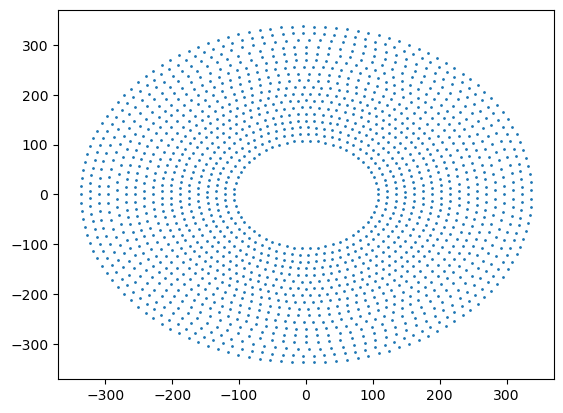

In [ ]:
def plot_matrix(matrix):
    import matplotlib.pyplot as plt
    plt.scatter(matrix.x.detach().numpy(), matrix.y.detach().numpy(),s = 1)
    plt.show()

plot_matrix(matrix)

In [ ]:
pd.DataFrame((matrix.H*matrix.W).detach().numpy().T).to_csv('area.csv')

In [ ]:
pd.DataFrame(eta.detach().numpy()).to_csv('eta.csv')